<a href="https://colab.research.google.com/github/SaidaAourras/EcoVolt/blob/main/EcoVolt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Préparation des données temporelles

In [2]:
%ls ../

bin@      dev/     lib@     media/  python-apt/         sbin@  tools/
boot/     etc/     lib32@   mnt/    python-apt.tar.xz*  srv/   usr/
content/  home/    lib64@   opt/    root/               sys/   var/
datalab/  kaggle/  libx32@  proc/   run/                tmp/


In [3]:
import pandas as pd
from google.colab import drive

# Monter Drive
drive.mount('/content/drive')
df = pd.read_csv('../content/drive/MyDrive/EcoVolt/dataset.csv')
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime")
df.set_index("DateTime", inplace=True) # set the index to become the "DateTime" column
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54170 entries, 2019-01-01 00:00:00 to 2025-03-19 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Consumption    54170 non-null  int64
 1   Production     54170 non-null  int64
 2   Nuclear        54170 non-null  int64
 3   Wind           54170 non-null  int64
 4   Hydroelectric  54170 non-null  int64
 5   Oil and Gas    54170 non-null  int64
 6   Coal           54170 non-null  int64
 7   Solar          54170 non-null  int64
 8   Biomass        54170 non-null  int64
dtypes: int64(9)
memory usage: 4.1 MB
None


**Pourquoi l’ordre temporel est critique**
- Déjà, le but du projet est de prédire le taux de consommation d'une heure au futur en se basant sur les données de 24 heures précédentes , ce qu'est fait l'odre temporel est tres important .

**Pourquoi on ne mélange pas les données (pas de shuffle)**

- Le shuffle détruirait la continuité temporelle nécessaire pour créer des séquences de 24 heures consécutives. On perdrait le contexte temporel qui est l'essence même du problème.

### 2. Normalisation des données

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaleddata = scaler.fit_transform(df)

**Pourquoi la normalisation
est indispensable en Deep Learning**

- La normalisation des données améliore la convergence des algorithmes de Deep Learning en mettant les features sur la même échelle. Sans elle, les variables de grande amplitude dominent les calculs et rendent l’entraînement numériquement instable. De plus, les fonctions d’activation comme sigmoid ou tanh fonctionnent mieux avec des valeurs normalisées, ce qui évite la saturation des gradients.

**Pourquoi MinMax est souvent préféré à StandardScaler pour LSTM**

- Le **MinMaxScaler** est privilégié car il normalise les données entre 0 et 1, ce qui est naturellement compatible avec les fonctions d’activation sigmoid et tanh. Il ne fait aucune hypothèse sur la distribution des données et préserve les proportions entre les valeurs, un point important pour les données énergétiques.

  À l’inverse, le **StandardScaler**, basé sur la moyenne et l’écart-type, peut poser problème en présence d’outliers et provoquer la saturation des fonctions d’activation.


### 3. Création des séquences

In [5]:
import numpy as np
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])  # Consumption
    return np.array(X), np.array(y)
X, y = create_sequences(scaleddata, window=24)

**Pourquoi un LSTM attend des données en 3D**

**Signification de la forme : (samples, timesteps, features)**

- Les LSTM traitent des séquences et ont besoin de comprendre :

  - Samples : Combien d'exemples d'entraînement (nombre de séquences)

  - Timesteps : Longueur de chaque séquence (ici 24 heures)

  - Features : Nombre de variables par timestep (ici 9 : Consumption + 8 sources d'énergie)

- Format requis : (samples, timesteps, features)

### 4. Split Train / Test (temporel)

In [6]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Pourquoi on ne fait pas de traintestsplit classique**

- La fonction train_test_split de sklearn mélange aléatoirement les données, ce qui est catastrophique pour les séries temporelles.

**Risque de fuite de données temporelles**

- Exemple de fuite :

  - Si on mélange, une séquence de mars 2024 pourrait être dans le training set
  - Et une séquence de février 2024 dans le test set
  - Le modèle "verrait le futur" pendant l'entraînement

- Solution : Split chronologique

### 5. Architecture LSTM

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential([
    LSTM(64, input_shape=(24, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer="adam",
    loss="mse"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Impact du nombre d’unités LSTM**

- Plus d'unités (ex: 128, 256) :

  - Capacité d'apprentissage accrue
  - Risque de surapprentissage si peu de données


- Moins d'unités (ex: 32, 16) :

    - Modèle plus simple
  - Risque de sous-apprentissage

**Différence entre 1 ou plusieurs couches LSTM**

- 1 couche LSTM (architecture ci-dessus) :

  - Suffisant pour des patterns simples (cycles journaliers)
  - Plus rapide à entraîner

- Plusieurs couches (exemple) :

  - Capture des patterns plus complexes (tendances à long terme + variations court terme)
  - Plus puissant mais risque d'overfitting

### 6. Entrainement & Monitoring

In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0177 - val_loss: 0.0013
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0029 - val_loss: 8.9754e-04
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0020 - val_loss: 7.5059e-04
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0015 - val_loss: 5.5326e-04
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0011 - val_loss: 5.0093e-04
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 9.1924e-04 - val_loss: 5.3906e-04
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 8.0479e-04 - val_loss: 4.6889e-04
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 7.6807e-04 - val_loss: 4.1698e-04
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 7.2008e-04 - val_loss: 4.1792e-04
Epoch 10/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 6.6622e-04 - val_loss: 4.9390e-04
Epoch 11/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 

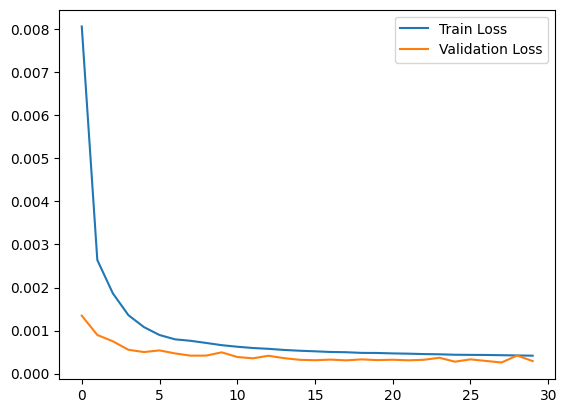

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

**Courbe loss vs val_loss**

- Interprétation des courbes :

  1 - Loss décroissante + Val_loss décroissante

    - Apprentissage sain
    - Le modèle généralise bien


  2- Loss décroissante + Val_loss stagne ou augmente

    - Surapprentissage (overfitting)
    - Le modèle mémorise le training set
    - Solutions : Dropout plus élevé, Early Stopping, moins d'epochs


  3 - Loss et Val_loss élevées

    - Sous-apprentissage
    - Modèle trop simple ou pas assez d'epochs

**Détection du surapprentissage**

 - Pas de Surapprentissage (Overfitting)

    - La Validation Loss ne remonte pas après avoir baissé
    - Elle ne diverge pas de la Train Loss
    - Conclusion : Votre modèle n'est PAS en overfitting

### 7. Evaluation du modèle

339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


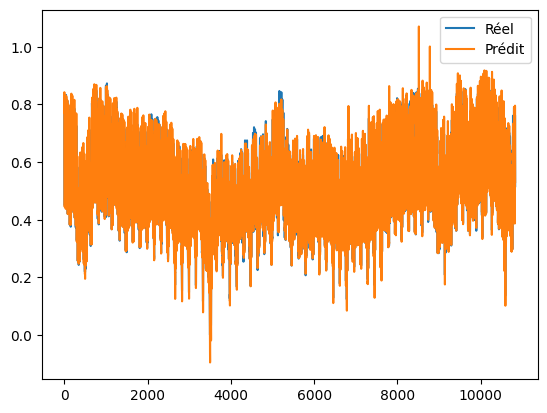

In [11]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
plt.plot(y_test, label="Réel")
plt.plot(y_pred, label="Prédit")
plt.legend()
plt.show()

### save graphs

In [15]:
from google.colab import drive
import matplotlib.pyplot as plt
import os

# Monter Drive
drive.mount('/content/drive')

# Créer le dossier
os.makedirs('/content/drive/MyDrive/EcoVolt/images', exist_ok=True)

plt.savefig('/content/drive/MyDrive/EcoVolt/images/predictions_vs_actual.png',
            dpi=300, bbox_inches='tight')

print("✅ Image sauvegardée dans Drive !")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Image sauvegardée dans Drive !


<Figure size 640x480 with 0 Axes>